In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
import warnings
from matplotlib import pyplot
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")


#  Data pre-processing

In [97]:
adult_df = pd.read_csv("data/adult.csv")

adult_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,1


In [85]:
adult_df = adult_df.sample(frac=1, random_state=10)

holdout = adult_df[:3000]
adult_df = adult_df[:-3000]

In [86]:
print(len(adult_df))
print(len(holdout))

29561
3000


In [87]:
adult_df = adult_df.replace('?', pd.np.nan)

adult_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [88]:
adult_df["workclass"].fillna(value=adult_df['workclass'].mode()[0],inplace=True)

adult_df["occupation"].fillna(value=adult_df['occupation'].mode()[0],inplace=True)

adult_df["native.country"].fillna(value=adult_df['native.country'].mode()[0],inplace=True)

## Data Visualisation

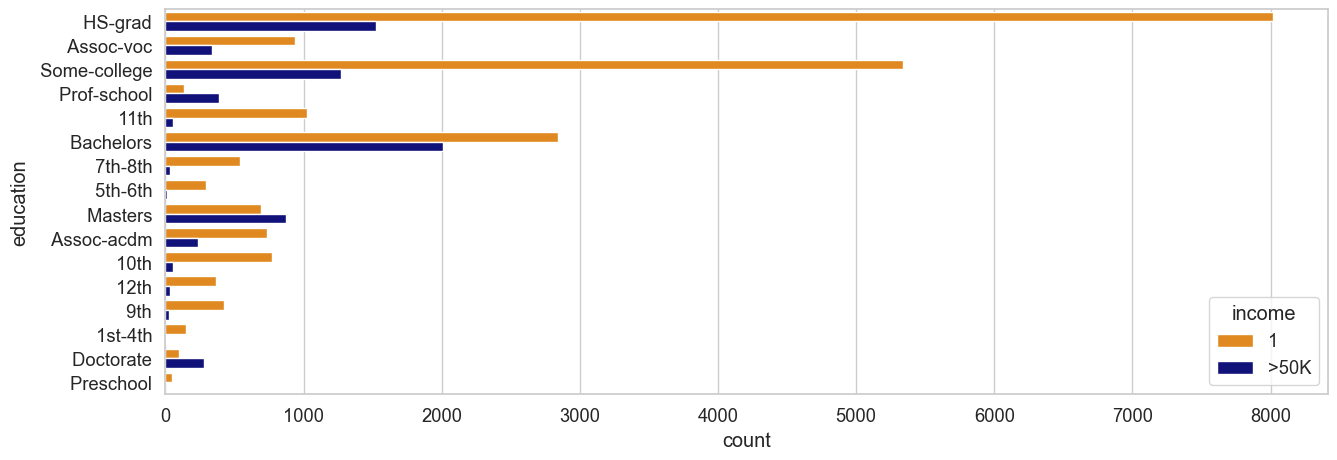

In [89]:
sns.set(style="whitegrid", font_scale=1.2)

a4_dims = (15, 5)

fig, ax = pyplot.subplots(figsize=a4_dims)

custom_palette = ["darkorange", "darkblue"]

g = sns.countplot(y="education", hue="income", data=adult_df, palette=custom_palette)

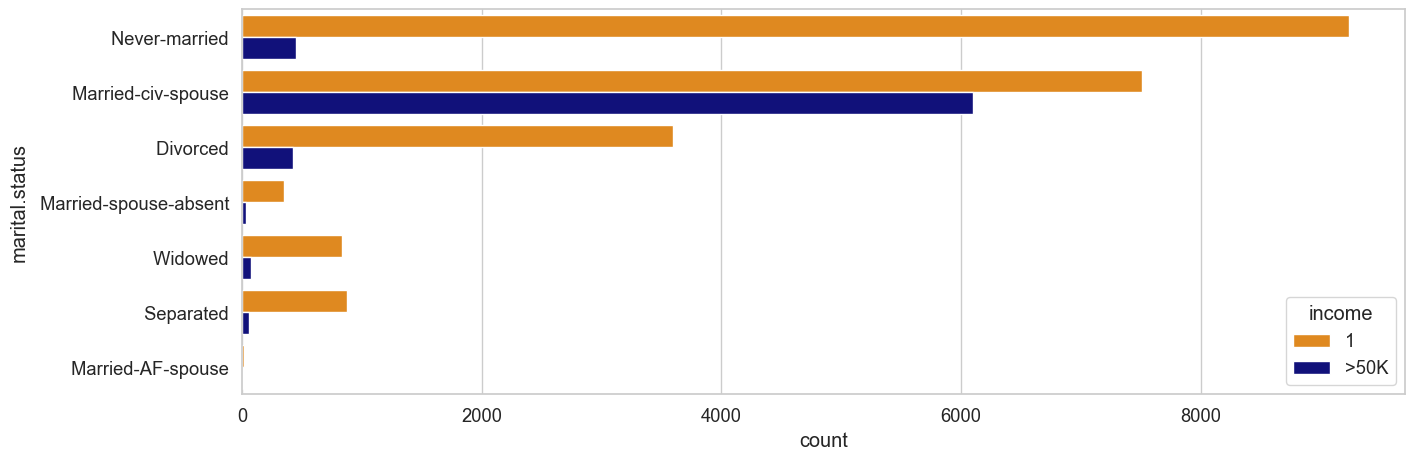

In [90]:
sns.set(style="whitegrid", font_scale=1.2)

a4_dims = (15, 5)

fig, ax = pyplot.subplots(figsize=a4_dims)

custom_palette = ["darkorange", "darkblue"]

g = sns.countplot(y="marital.status", hue="income", data=adult_df, palette=custom_palette)

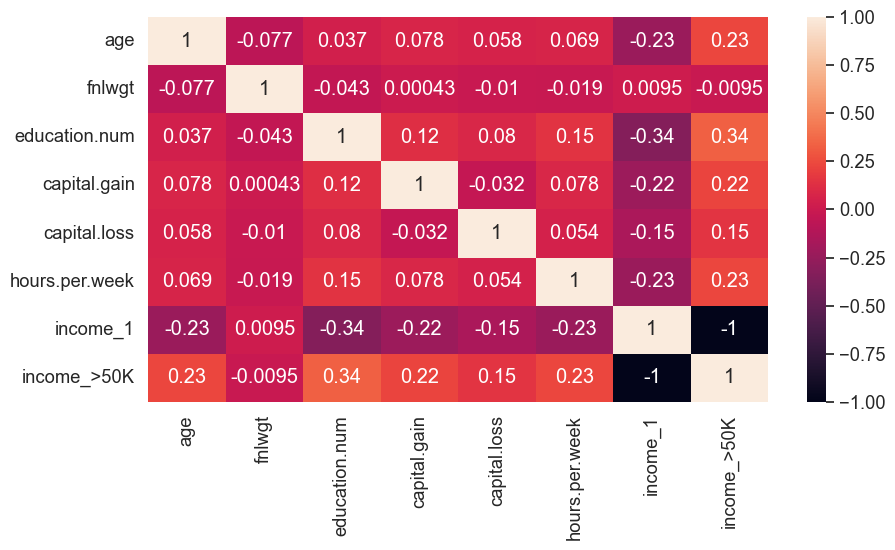

In [98]:
 
adult_df = pd.get_dummies(adult_df, columns=['income'])
    

#adult_df.drop(columns=['income_<=50K'], inplace=True)

# Calculate the correlation matrix
corr = adult_df.corr()

# Set the dimensions for the heatmap figure
plt.figure(figsize=(10, 5))

# Create a heatmap visualization with annotations
sns.heatmap(corr, annot=True)

# Show the heatmap
plt.show()

# Feature Selection

Firstly, we will convert our categorical variables to numerical ones using the method of one-hot encoding.

In [99]:
adult_df2 = adult_df.copy()
adult_df = pd.get_dummies(adult_df, columns=['occupation', 'race', 'workclass', 'marital.status', 'relationship'])

In [100]:
adult_df.corr().unstack().sort_values().drop_duplicates()

income_1                            income_>50K                          -1.000000
race_ White                         race_ Black                          -0.788747
marital.status_ Never-married       marital.status_ Married-civ-spouse   -0.644866
                                    relationship_ Husband                -0.576730
marital.status_ Married-civ-spouse  relationship_ Not-in-family          -0.537588
                                                                            ...   
income_>50K                         marital.status_ Married-civ-spouse    0.444696
relationship_ Own-child             marital.status_ Never-married         0.509226
relationship_ Husband               marital.status_ Married-civ-spouse    0.893210
workclass_ ?                        occupation_ ?                         0.997985
age                                 age                                   1.000000
Length: 1226, dtype: float64

In [101]:
adult_df = adult_df2
adult_df = pd.get_dummies(adult_df, columns=['occupation', 'race', 'workclass', 'marital.status'])

In [102]:
adult_df['new_educ_num'] = adult_df.apply(lambda x: x['education.num']-8 if x['education.num'] >= 9 else 0, axis=1)


This is asking to investigate the correlation between the new variable that groups the first 8 educational levels and the "income_>50K" variable.

In [104]:
X = adult_df.drop([ 'education', 'sex', 'native.country', 'education.num', 'relationship'], axis=1)

y = adult_df[['income_>50K']]

test = SelectPercentile(score_func=chi2, percentile=16)

fit = test.fit(X, y)

X.columns[test.get_support()]

Index(['age', 'fnlwgt', 'capital.gain', 'capital.loss', 'income_1',
       'income_>50K', 'new_educ_num'],
      dtype='object')

In [105]:
adult_df.head()

,age,fnlwgt,education,education.num,relationship,sex,capital.gain,capital.loss,hours.per.week,native.country,...,workclass_ State-gov,workclass_ Without-pay,marital.status_ Divorced,marital.status_ Married-AF-spouse,marital.status_ Married-civ-spouse,marital.status_ Married-spouse-absent,marital.status_ Never-married,marital.status_ Separated,marital.status_ Widowed,new_educ_num
0,39,77516,Bachelors,13,Not-in-family,Male,2174,0,40,United-States,...,1,0,0,0,0,0,1,0,0,5
1,50,83311,Bachelors,13,Husband,Male,0,0,13,United-States,...,0,0,0,0,1,0,0,0,0,5
2,38,215646,HS-grad,9,Not-in-family,Male,0,0,40,United-States,...,0,0,1,0,0,0,0,0,0,1
3,53,234721,11th,7,Husband,Male,0,0,40,United-States,...,0,0,0,0,1,0,0,0,0,0
4,28,338409,Bachelors,13,Wife,Female,0,0,40,Cuba,...,0,0,0,0,1,0,0,0,0,5


The next step after selecting our features is to normalize our variables since SVMs are sensitive to the scale of their features.

In [106]:
X = adult_df[['age', 'fnlwgt', 'capital.gain', 'capital.loss', 
              'hours.per.week','marital.status_ Married-civ-spouse', 'new_educ_num']]

scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

# Modeling and Evaluation

In [107]:
model = LinearSVC(max_iter = 10000, dual=False)

model.fit(X, y.values.ravel())

LinearSVC(dual=False, max_iter=10000)

In [108]:
holdout['new_educ_num'] = holdout.apply(lambda x: x['education.num']-8 if x['education.num'] >= 9 else 0, axis=1)

holdout = pd.get_dummies(holdout, columns=['occupation', 'race', 'workclass', 'marital.status', 'income'])

test_X = holdout[['age', 'fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week',
       'marital.status_ Married-civ-spouse', 'new_educ_num']]

test_y = holdout[['income_>50K']]

test_X = scaler.transform(test_X)

y_pred = model.predict(test_X)

Now we can see the classification report to evaluate our model's performance.

In [109]:
print(classification_report(test_y, y_pred, target_names=['Income more than 50K', 'Income less than 50K']))

                      precision    recall  f1-score   support

Income more than 50K       0.86      0.93      0.90      2258
Income less than 50K       0.72      0.55      0.62       742

            accuracy                           0.84      3000
           macro avg       0.79      0.74      0.76      3000
        weighted avg       0.83      0.84      0.83      3000



In [110]:
C_range = [0.1, 1, 10, 100]

gamma_vals = [0.001, 0.0001, 'scale']

param_grid = dict(gamma=gamma_vals, C=C_range)

grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=10)

grid.fit(X, y.values.ravel())

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

KeyboardInterrupt: 

Now we should train the SVM model using the optimal hyperparameters found using grid search. 

In [ ]:
model = SVC(kernel='rbf', **grid.best_params_)

In [ ]:
model = model.fit(X, y.values.ravel())

y_pred = model.predict(test_X)

In [ ]:
print(classification_report(test_y, y_pred, target_names=['Income more than 50K', 'Income less than 50K']))

The kernelized SVM produced a slightly better result than the simple linear SVM, with a low recall still observed for "Income less than 50K" class. Despite the longer training time, the kernelized SVM is considered a better model as it has better predictive power for both classes.

In [ ]:
sns.heatmap(confusion_matrix(test_y,  y_pred),annot = True, fmt = 'd')

plt.title("Confusion Matrix")

plt.xlabel("Predicted")

plt.ylabel("True")

plt.show()

In [ ]:
y_score = model.decision_function(test_X)

fpr, tpr, thresholds = roc_curve(test_y, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Random guessing')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
